# *Machine Learning* para Predicción Temporal

## Series Temporales y Descomposición

### Teoría
Una serie temporal es una secuencia de datos ordenados en el tiempo. Para modelarla, primero debemos entender sus componentes:
- **Tendencia ($T_t$)**: Movimiento a largo plazo.
- **Estacionalidad ($S_t$)**: Patrones que se repiten periódicamente.
- **Residual ($I_t$)**: Ruido aleatorio no explicado.

En un modelo aditivo: 
$$Y[t] = T[t] + S[t] + I[t]$$

### Ejemplo

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# Crear datos sintéticos
np.random.seed(42)
fechas = pd.date_range(start='2020-01-01', periods=365, freq='D')
tendencia = np.linspace(100, 200, 365)
estacionalidad = 20 * np.sin(2 * np.pi * np.arange(365) / 30)
ruido = np.random.normal(0, 5, 365)
serie = tendencia + estacionalidad + ruido

# Crear DataFrame
df = pd.DataFrame({
    'Fecha': fechas,
    'Valor': serie
})
df.set_index('Fecha', inplace=True)

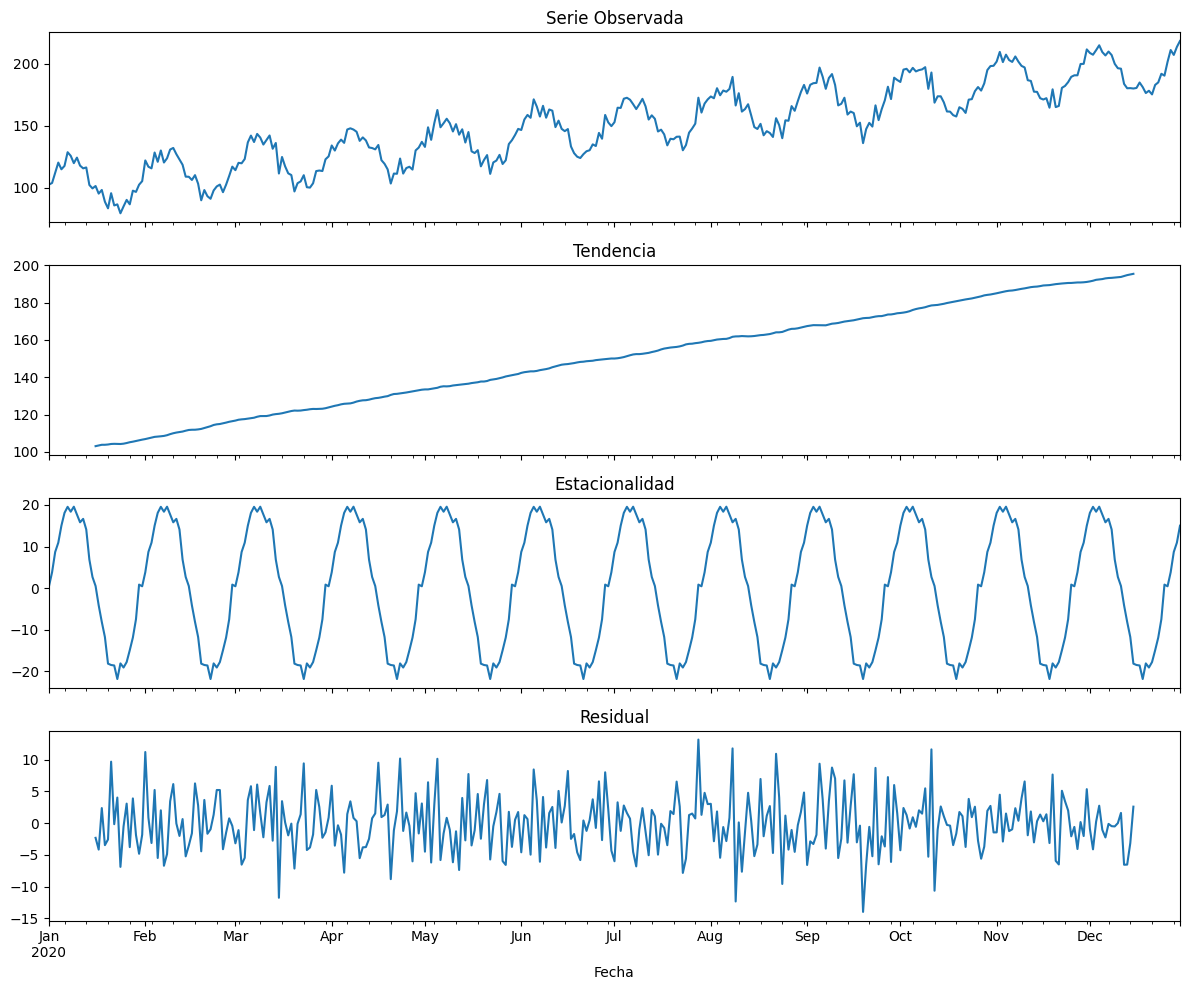

In [2]:
# Descomposición
resultado = seasonal_decompose(df['Valor'], model='additive', period=30)

# Visualizar
fig, axes = plt.subplots(4, 1, figsize=(12, 10), sharex=True)
resultado.observed.plot(ax=axes[0], title='Serie Observada')
resultado.trend.plot(ax=axes[1], title='Tendencia')
resultado.seasonal.plot(ax=axes[2], title='Estacionalidad')
resultado.resid.plot(ax=axes[3], title='Residual')
plt.tight_layout()
plt.show()

#### Explicación
- `seasonal_decompose()`: Descompone una serie en sus componentes.
- `model='additive'`: Especifica modelo aditivo (también existe `'multiplicative'`).
- `period=30`: Define el período estacional (30 días).

#### Parámetros Clave
- `period`: Período de repetición estacional.
- `model`: Tipo de modelo (`'additive'` o `'multiplicative'`).

### Notas de Examen
- La descomposición ayuda a identificar patrones antes de modelar.
- En modelos aditivos, los componentes se suman; en multiplicativos, se multiplican.
- Un residual con media cero y varianza constante indica buen ajuste.



## Modelos ARIMA

### Teoría
ARIMA (*Autoregressive Integrated Moving Average*) modela series temporales mediante:
- **AR(p)**: Componente autorregresivo de orden p.
- **I(d)**: Diferenciación de orden d para lograr estacionariedad.
- **MA(q)**: Media móvil de orden q.

El modelo se denota ARIMA(p,d,q). Para series con estacionalidad, se usa SARIMA.

### Ejemplo

RMSE: 46.00


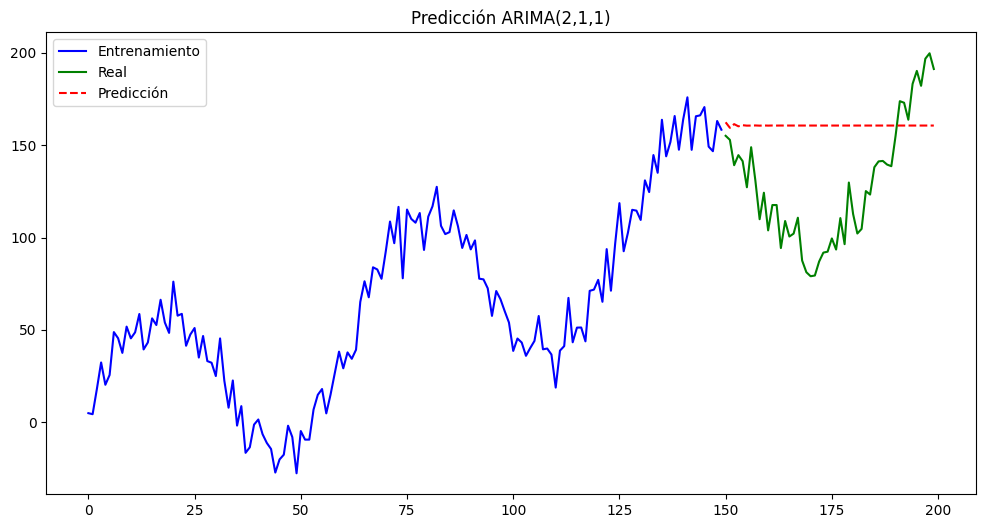

In [3]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

# Crear serie sintética
np.random.seed(42)
n = 200
serie = 0.8 * np.arange(n) + 50 * np.sin(0.1 * np.arange(n)) + np.random.normal(0, 10, n)

# Dividir en train/test
train = serie[:150]
test = serie[150:]

# Ajustar modelo ARIMA(2,1,1)
modelo = ARIMA(train, order=(2, 1, 1))
modelo_ajustado = modelo.fit()

# Predecir
predicciones = modelo_ajustado.forecast(steps=50)

# Calcular RMSE
rmse = np.sqrt(mean_squared_error(test, predicciones))
print(f"RMSE: {rmse:.2f}")

# Visualizar
plt.figure(figsize=(12,6))
plt.plot(np.arange(150), train, label='Entrenamiento', color='blue')
plt.plot(np.arange(150, 200), test, label='Real', color='green')
plt.plot(np.arange(150, 200), predicciones, label='Predicción', color='red', linestyle='--')
plt.legend()
plt.title('Predicción ARIMA(2,1,1)')
plt.show()

#### Explicación
- `ARIMA()`: Crea modelo ARIMA.
- `order=(p,d,q)`: Especifica los órdenes del modelo.
- `fit()`: Ajusta el modelo a los datos.
- `forecast()`: Genera predicciones futuras.

#### Parámetros Clave
- `p`: Número de términos autorregresivos.
- `d`: Número de diferenciaciones.
- `q`: Número de términos de media móvil.

### Notas de Examen
- ARIMA requiere series estacionarias (media y varianza constantes).
- Para determinar p y q, se analizan ACF y PACF.
- Diferenciación (d) elimina tendencias.
- AIC/BIC ayudan a seleccionar el mejor modelo.

## Modelos Supervisados para Series Temporales

### Teoría
Los modelos clásicos de ML (regresión lineal, SVM, Random Forest) no incorporan temporalidad directamente. Debemos crear *features* temporales como:
- **Lags**: Valores pasados ($y_{t-1}$, $y_{t-2}$, ...)
- **Ventanas móviles**: Medias/desviaciones de períodos anteriores.
- **Componentes temporales**: Día de la semana, mes, etc.

### Ejemplo

In [4]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Crear dataset sintético con múltiples features
np.random.seed(42)
n = 500
X1 = np.cumsum(np.random.randn(n))  # Feature 1
X2 = np.sin(0.1 * np.arange(n))     # Feature 2
X3 = np.log(1 + np.arange(n))       # Feature 3
ruido = np.random.normal(0, 0.5, n)

# Target con dependencia de features anteriores
y = 2*X1 + 3*X2 + 0.5*X3 + ruido

# Crear DataFrame con lags
df = pd.DataFrame({
    'y': y,
    'X1': X1,
    'X2': X2,
    'X3': X3
})

In [5]:
# Crear lags (features temporales)
for i in range(1, 4):
    df[f'X1_lag{i}'] = df['X1'].shift(i)
    df[f'X2_lag{i}'] = df['X2'].shift(i)

# Eliminar NaN
df = df.dropna()

# Separar features y target
X = df.drop('y', axis=1)
y = df['y']

# Dividir datos (manteniendo orden temporal)
split_idx = int(0.8 * len(X))
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

In [6]:
# Probar múltiples modelos
modelos = {
    'Regresión Lineal': LinearRegression(),
    'SVR': SVR(kernel='rbf', C=100),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42)
}


In [7]:

resultados = {}
for nombre, modelo in modelos.items():
    # Entrenar
    modelo.fit(X_train, y_train)
    
    # Predecir
    y_pred_train = modelo.predict(X_train)
    y_pred_test = modelo.predict(X_test)
    
    # Evaluar
    mse_train = mean_squared_error(y_train, y_pred_train)
    mse_test = mean_squared_error(y_test, y_pred_test)
    r2_train = r2_score(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred_test)
    
    resultados[nombre] = {
        'MSE_train': mse_train,
        'MSE_test': mse_test,
        'R2_train': r2_train,
        'R2_test': r2_test
    }
    
    print(f"{nombre}:")
    print(f"  MSE train: {mse_train:.4f}, test: {mse_test:.4f}")
    print(f"  R² train: {r2_train:.4f}, test: {r2_test:.4f}")


Regresión Lineal:
  MSE train: 0.2308, test: 0.2408
  R² train: 0.9986, test: 0.9945
SVR:
  MSE train: 0.2125, test: 14.2029
  R² train: 0.9987, test: 0.6729
Random Forest:
  MSE train: 0.1353, test: 9.0692
  R² train: 0.9992, test: 0.7912


#### Explicación
- Se crean *lags* para incorporar información temporal.
- `shift(i)`: Desplaza la serie i períodos.
- Se comparan tres modelos: lineal, no lineal (SVR) y ensemble (Random Forest).

#### Parámetros Clave
- `n_estimators`: Número de árboles en Random Forest.
- `kernel`: Tipo de kernel en SVR (`'linear'`, `'rbf'`, `'poly'`).
- `C`: Parámetro de regularización en SVR.

### Notas de Examen
- En series temporales, NO usar `train_test_split` aleatorio (rompe dependencia temporal).
- Crear *features* temporales es esencial para ML clásico.
- Random Forest suele funcionar bien con datos complejos pero es menos interpretable.


## Regularización

### Teoría
La regularización penaliza coeficientes grandes para evitar *overfitting*:

**Ridge Regression (L2)**:
$$J(w)_{Ridge} = \sum^n_{i=1}(y^{(i)}-\hat{y}^{(i)})^2 + \lambda\| w \|_2^2$$

**Lasso Regression (L1)**:
$$J(w)_{Lasso} = \sum^n_{i=1}(y^{(i)}-\hat{y}^{(i)})^2 + \lambda\| w \|_1$$

**Elastic Net** (combinación):
$$J(w)_{ElasticNet} = \sum^n_{i=1}(y^{(i)}-\hat{y}^{(i)})^2 + \lambda_1 \| w \|_1 + \lambda_2 \| w \|_2^2$$

### Ejemplo

In [9]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Crear datos sintéticos con multicolinealidad
np.random.seed(42)
n_samples, n_features = 100, 10
X = np.random.randn(n_samples, n_features)

# Crear features correlacionadas
X[:, 3] = X[:, 0] + 0.5 * np.random.randn(n_samples)
X[:, 5] = X[:, 1] - 0.3 * np.random.randn(n_samples)

# True coefficients (algunos cero)
coef = np.array([2.5, -1.8, 0, 0, 1.2, 0, 0, 0.7, 0, 0])
y = X @ coef + np.random.randn(n_samples) * 0.5

# Dividir datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [10]:
# Probar diferentes regularizaciones
modelos = {
    'Ridge (α=1)': Ridge(alpha=1.0),
    'Lasso (α=0.1)': Lasso(alpha=0.1),
    'ElasticNet (α=0.1, l1_ratio=0.5)': ElasticNet(alpha=0.1, l1_ratio=0.5)
}

for nombre, modelo in modelos.items():
    # Crear pipeline con escalado
    pipe = make_pipeline(StandardScaler(), modelo)
    
    # Entrenar
    pipe.fit(X_train, y_train)
    
    # Evaluar
    score_train = pipe.score(X_train, y_train)
    score_test = pipe.score(X_test, y_test)
    
    print(f"{nombre}:")
    print(f"  R² train: {score_train:.4f}, test: {score_test:.4f}")
    
    # Mostrar coeficientes (solo para modelos lineales)
    if hasattr(modelo, 'coef_'):
        coef_modelo = modelo.coef_
        print(f"  Coef no cero: {(coef_modelo != 0).sum()}/{len(coef_modelo)}")

Ridge (α=1):
  R² train: 0.9794, test: 0.9628
  Coef no cero: 10/10
Lasso (α=0.1):
  R² train: 0.9762, test: 0.9628
  Coef no cero: 5/10
ElasticNet (α=0.1, l1_ratio=0.5):
  R² train: 0.9726, test: 0.9564
  Coef no cero: 7/10


#### Explicación
- `Ridge`: Penaliza L2, reduce magnitud pero no elimina coeficientes.
- `Lasso`: Penaliza L1, puede eliminar coeficientes (selección de features).
- `ElasticNet`: Combina L1 y L2.
- `StandardScaler`: Escala features para que penalizaciones sean comparables.

#### Parámetros Clave
- `alpha` ($\lambda$): Fuerza de regularización.
- `l1_ratio`: Proporción L1 en Elastic Net (0=Ridge, 1=Lasso).

### Notas de Examen
- Ridge es mejor cuando todos los predictores son relevantes.
- Lasso realiza selección automática de variables.
- Elastic Net es útil cuando hay más predictores que muestras.
- Siempre escalar features antes de regularizar.


## Regresión Polinómica

### Teoría
Transforma features originales en términos polinómicos para capturar no linealidades:
$$y = w_0 + w_1x + w_2x^2 + ... + w_dx^d$$

Sigue siendo lineal en los parámetros $w$, por lo que se resuelve con mínimos cuadrados.

### Ejemplo


In [12]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

# Crear datos no lineales
np.random.seed(42)
X = np.linspace(-3, 3, 100)
y = 0.5 * X**3 - 2 * X**2 + X + np.random.randn(100) * 0.5

Grado 1: R² = 0.5617
Grado 3: R² = 0.9975
Grado 5: R² = 0.9975
Grado 10: R² = 0.9976


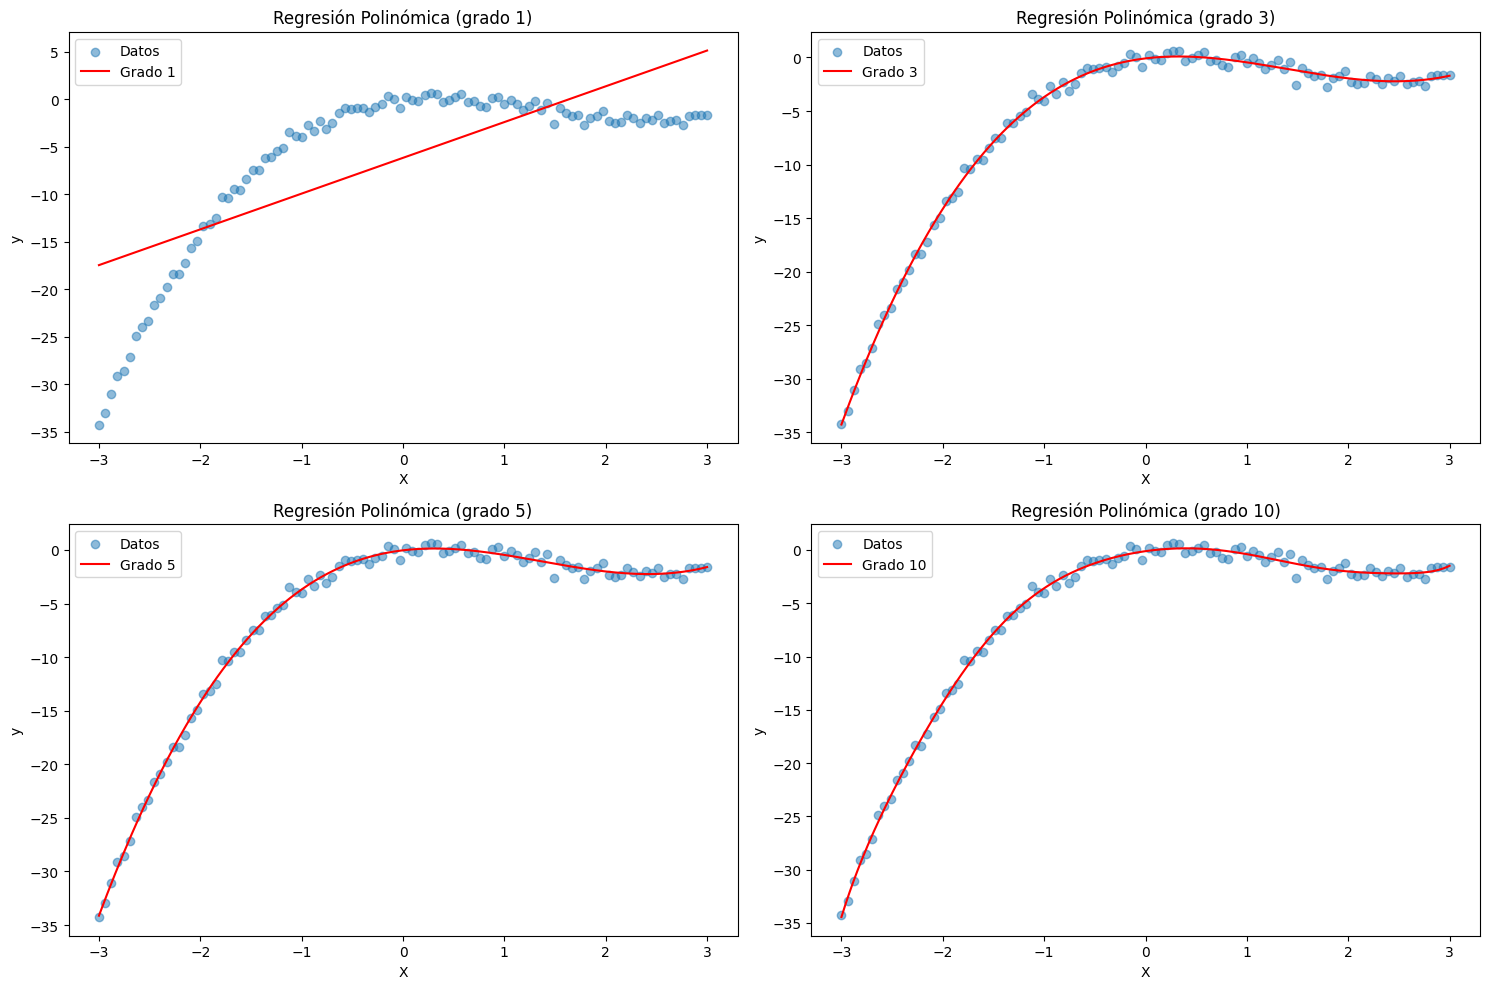

In [13]:
# Reshape para sklearn
X = X.reshape(-1, 1)

# Probar diferentes grados
grados = [1, 3, 5, 10]
plt.figure(figsize=(15, 10))

for i, grado in enumerate(grados):
    # Crear features polinómicas
    poly = PolynomialFeatures(degree=grado)
    X_poly = poly.fit_transform(X)
    
    # Ajustar modelo lineal
    modelo = LinearRegression()
    modelo.fit(X_poly, y)
    
    # Predecir
    X_test = np.linspace(-3, 3, 300).reshape(-1, 1)
    X_test_poly = poly.transform(X_test)
    y_pred = modelo.predict(X_test_poly)
    
    # Graficar
    plt.subplot(2, 2, i+1)
    plt.scatter(X, y, alpha=0.5, label='Datos')
    plt.plot(X_test, y_pred, 'r-', label=f'Grado {grado}')
    plt.title(f'Regresión Polinómica (grado {grado})')
    plt.xlabel('X')
    plt.ylabel('y')
    plt.legend()
    
    # Calcular R²
    r2 = modelo.score(X_poly, y)
    print(f"Grado {grado}: R² = {r2:.4f}")

plt.tight_layout()
plt.show()

#### Explicación
- `PolynomialFeatures`: Genera términos polinómicos.
- `degree`: Grado máximo del polinomio.
- Se usa con `LinearRegression` para ajuste.

#### Parámetros Clave
- `degree`: Grado del polinomio.
- `interaction_only`: Si True, solo incluye términos de interacción.
- `include_bias`: Si incluir término de bias (intercepto).

### Notas de Examen
- Alto grado puede causar *overfitting*.
- Regularización (Ridge/Lasso) ayuda con polinomios de alto grado.
- El número de features crece combinatoriamente con el grado.

## Árboles de Decisión para Regresión

### Teoría
Los árboles dividen el espacio de features en regiones y predicen el valor medio de cada región. 
Divide recursivamente según features que minimizan el error (generalmente MSE).

### Ejemplo


In [14]:
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.model_selection import cross_val_score

# Crear datos no lineales
np.random.seed(42)
X = np.sort(5 * np.random.rand(100, 1), axis=0)
y = np.sin(X).ravel() + np.random.randn(100) * 0.1

Profundidad 2: MSE CV = 0.1981
Profundidad 4: MSE CV = 0.0928
Profundidad 6: MSE CV = 0.0941
Profundidad 10: MSE CV = 0.0882


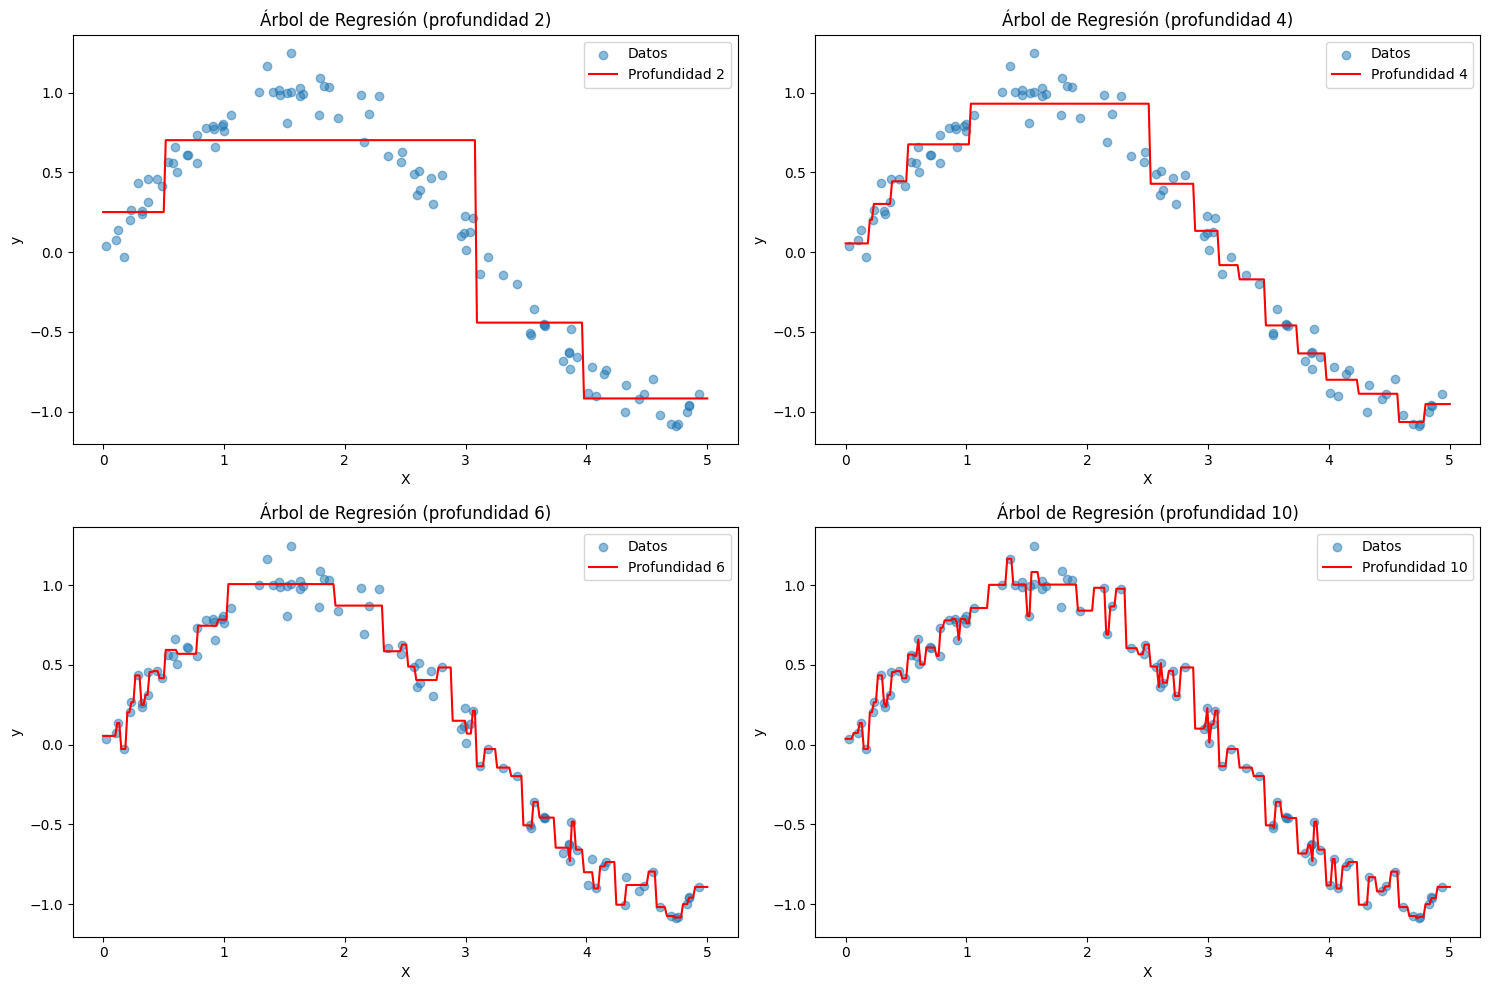

In [15]:
# Probar diferentes profundidades
profundidades = [2, 4, 6, 10]
plt.figure(figsize=(15, 10))

for i, profundidad in enumerate(profundidades):
    # Crear y entrenar modelo
    arbol = DecisionTreeRegressor(max_depth=profundidad, random_state=42)
    arbol.fit(X, y)
    
    # Predecir
    X_test = np.linspace(0, 5, 300).reshape(-1, 1)
    y_pred = arbol.predict(X_test)
    
    # Graficar
    plt.subplot(2, 2, i+1)
    plt.scatter(X, y, alpha=0.5, label='Datos')
    plt.plot(X_test, y_pred, 'r-', label=f'Profundidad {profundidad}')
    plt.title(f'Árbol de Regresión (profundidad {profundidad})')
    plt.xlabel('X')
    plt.ylabel('y')
    plt.legend()
    
    # Evaluar con validación cruzada
    scores = cross_val_score(arbol, X, y, cv=5, scoring='neg_mean_squared_error')
    mse_cv = -scores.mean()
    print(f"Profundidad {profundidad}: MSE CV = {mse_cv:.4f}")

plt.tight_layout()
plt.show()

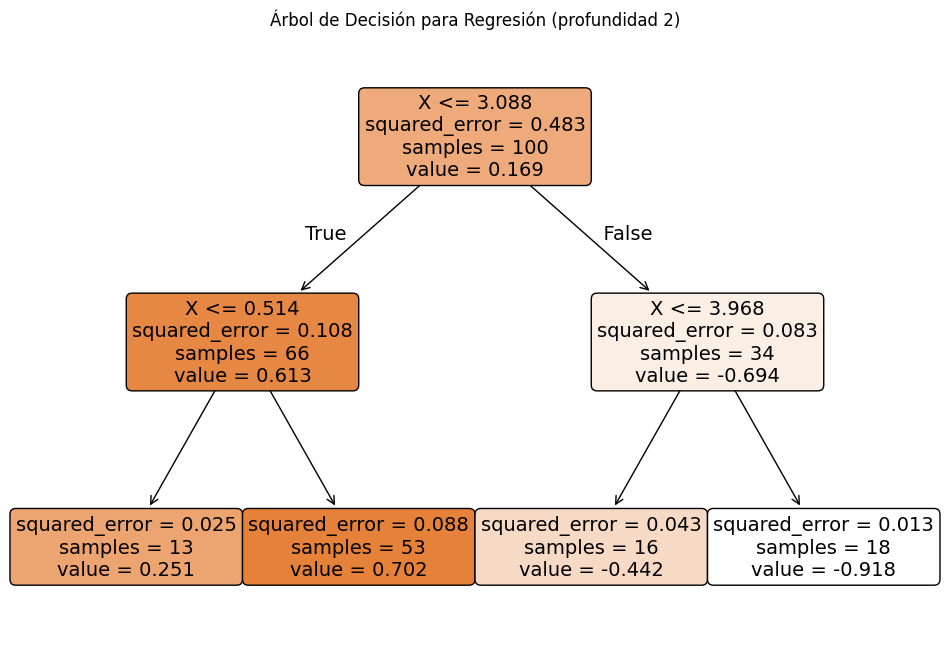

In [16]:
# Visualizar árbol (para profundidad 2)
arbol_simple = DecisionTreeRegressor(max_depth=2, random_state=42)
arbol_simple.fit(X, y)

plt.figure(figsize=(12, 8))
plot_tree(arbol_simple, filled=True, feature_names=['X'], rounded=True)
plt.title("Árbol de Decisión para Regresión (profundidad 2)")
plt.show()

#### Explicación
- `DecisionTreeRegressor`: Implementa árboles para regresión.
- `max_depth`: Profundidad máxima (controla complejidad).
- `plot_tree()`: Visualiza la estructura del árbol.

#### Parámetros Clave
- `max_depth`: Profundidad máxima.
- `min_samples_split`: Mínimo muestras para dividir nodo.
- `min_samples_leaf`: Mínimo muestras en hoja.
- `criterion`: Criterio de división (`'mse'`, `'friedman_mse'`, `'mae'`).

### Notas de Examen
- Árboles profundos tienden a *overfitting*.
- `max_depth` es el principal parámetro de regularización.
- Árboles no requieren escalado de features.
- Son interpretables pero inestables (pequeños cambios en datos cambian el árbol).

## Métricas de Regresión

### Teoría

**Error Cuadrático Medio (MSE)**:
$$MSE = \frac{1}{m}\sum_{j=1}^m (\hat{y}_j - y_j)^2$$

**Raíz del Error Cuadrático Medio (RMSE)**:
$$RMSE = \sqrt{MSE}$$

**Error Absoluto Medio (MAE)**:
$$MAE = \frac{1}{m}\sum_{j=1}^m |\hat{y}_j - y_j|$$

**Coeficiente de Determinación ($R^2$)**:
$$R^2 = 1 - \frac{\sum_{j=1}^m (\hat{y}_j - y_j)^2}{\sum_{j=1}^m (y_j - \bar{y})^2}$$

### Ejemplo

In [17]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Crear datos sintéticos
np.random.seed(42)
y_real = 2 * np.arange(100) + np.random.randn(100) * 10
y_pred = 1.9 * np.arange(100) + np.random.randn(100) * 12  # Predicciones con error

In [18]:
# Calcular métricas
mse = mean_squared_error(y_real, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_real, y_pred)
r2 = r2_score(y_real, y_pred)

print("Métricas de Regresión:")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R²: {r2:.4f}")

Métricas de Regresión:
MSE: 262.9066
RMSE: 16.2144
MAE: 13.2791
R²: 0.9240


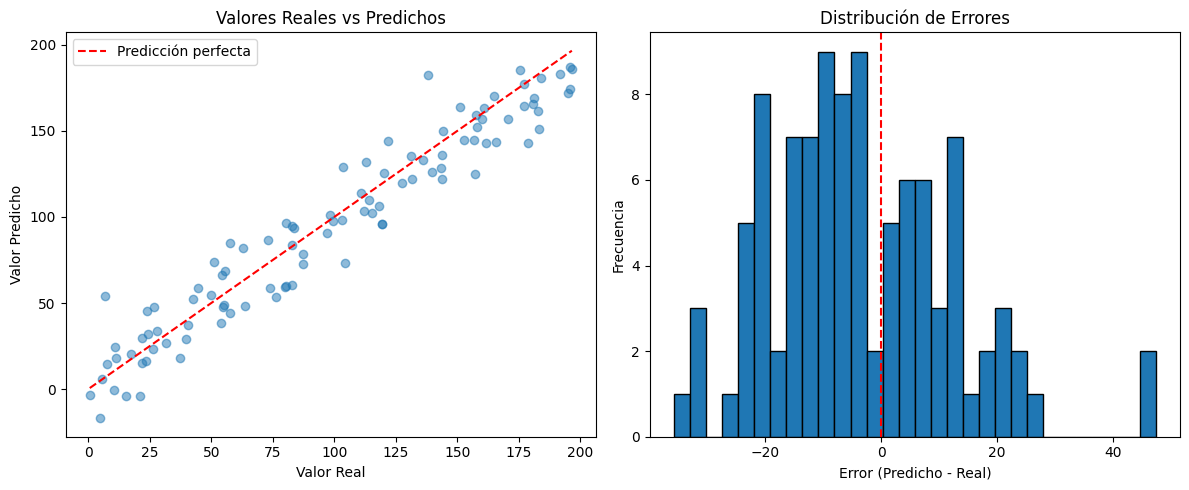

In [19]:
# Visualizar errores
errores = y_pred - y_real
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(y_real, y_pred, alpha=0.5)
plt.plot([y_real.min(), y_real.max()], [y_real.min(), y_real.max()], 'r--', label='Predicción perfecta')
plt.xlabel('Valor Real')
plt.ylabel('Valor Predicho')
plt.title('Valores Reales vs Predichos')
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(errores, bins=30, edgecolor='black')
plt.xlabel('Error (Predicho - Real)')
plt.ylabel('Frecuencia')
plt.title('Distribución de Errores')
plt.axvline(x=0, color='r', linestyle='--')

plt.tight_layout()
plt.show()

In [20]:
# Implementación manual de métricas
def mse_manual(y_real, y_pred):
    return np.mean((y_real - y_pred)**2)

def rmse_manual(y_real, y_pred):
    return np.sqrt(mse_manual(y_real, y_pred))

def mae_manual(y_real, y_pred):
    return np.mean(np.abs(y_real - y_pred))

def r2_manual(y_real, y_pred):
    ss_res = np.sum((y_real - y_pred)**2)
    ss_tot = np.sum((y_real - np.mean(y_real))**2)
    return 1 - (ss_res / ss_tot)

# Verificar igualdad
print("\nVerificación manual:")
print(f"MSE manual: {mse_manual(y_real, y_pred):.4f}")
print(f"RMSE manual: {rmse_manual(y_real, y_pred):.4f}")
print(f"MAE manual: {mae_manual(y_real, y_pred):.4f}")
print(f"R² manual: {r2_manual(y_real, y_pred):.4f}")


Verificación manual:
MSE manual: 262.9066
RMSE manual: 16.2144
MAE manual: 13.2791
R² manual: 0.9240


#### Explicación
- `mean_squared_error()`: Calcula MSE.
- `mean_absolute_error()`: Calcula MAE.
- `r2_score()`: Calcula R².
- RMSE se obtiene como raíz de MSE.

#### Interpretación
- **MSE/RMSE**: Penalizan más errores grandes (sensibles a *outliers*).
- **MAE**: Más robusto a *outliers*.
- **R²**: Proporción de varianza explicada (1=perfecto, 0=no explica nada, puede ser negativo).

### Notas de Examen
- RMSE está en unidades de la variable objetivo.
- R² alto en entrenamiento pero bajo en test indica *overfitting*.
- MSE es diferenciable (importante para optimización).
- Para comparar modelos, usar misma métrica y mismo conjunto de test.

## Conclusión

Este resumen cubre los conceptos clave de ML para predicción temporal:
1. **Análisis exploratorio** con descomposición de series.
2. **Modelos temporales específicos** como ARIMA.
3. **ML clásico** aplicado a series (creando *features* temporales).
4. **Regularización** para evitar *overfitting*.
5. **Modelos no lineales**: polinomiales y árboles.
6. **Métricas** para evaluar modelos de regresión.

Cada ejemplo de código es ejecutable independientemente y demuestra los conceptos teóricos. Para el examen, es crucial entender:
- Cuándo usar cada tipo de modelo.
- Cómo evaluar y comparar modelos.
- Los supuestos y limitaciones de cada técnica.